## TFIM (残留EE, 分割時間, 横磁場, 周期境界条件なし)

\[
H = - J \sum_i S_i^z S_{i+1}^z \;-\; h_x \sum_i S_i^x
\]

In [2]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

In [11]:
# =========
T_total, nt = 0.1, 500
# T_total, nt = 10.0, 200
tlist = np.linspace(0.0, T_total, nt)
# =========

def simulate(N, J, hx, T_cut):
    cut_pos = N // 2 - 1
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sy = [op_at(i, sy) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return (Sz[i] * Sz[i+1])

    def H_trans(i):
        return Sx[i]

    H_cut_unit = H_exchange(cut_pos)
    H_exchange_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    H_trans_unit = sum(H_trans(i) for i in range(N))
    H_full = -J * (H_exchange_unit + H_cut_unit) - hx * H_trans_unit

    H_static = -J * (H_exchange_unit) - hx * H_trans_unit
    left_sides = list(range(N//2))
    solver_opts = dict(store_states=False, progress_bar =None, rtol = 1e-6, atol=1e-8, nsteps=20000)


    def ramp(t, T_cut):
        if T_cut <= 0.0:
            return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0:
            return 1.0
        if t >= T_cut:
            return 0.0
        return 1.0 - t / T_cut

    def coeff(t, T_cut, J, args=None):
        return - J * ramp(t, T_cut)

    def make_H_time(T_cut: float, J: float):
        return [H_static, [ - J * H_cut_unit, lambda t, args: ramp(t, T_cut)]]

    def EE_op(t, state, args=None):
        rhoL = qt.ptrace(state, left_sides)
        return float(qt.entropy_vn(rhoL, base=2))

    def run_resi_EE_curve(T_cut: float, J: float, psi0):
        H_time = make_H_time(T_cut, J)
        sol = qt.sesolve(H_time, psi0, tlist, e_ops=[EE_op], options=solver_opts)
        # 最後の値のみとってきている
        return np.array(sol.expect[0])[-1]


    _, psi_ground = H_full.groundstate(sparse=True)
    return run_resi_EE_curve(T_cut, J, psi_ground)

--- Calculating for hx = 0.1 ---
[0.9997208  1.00000608 1.00000893 1.00000896]


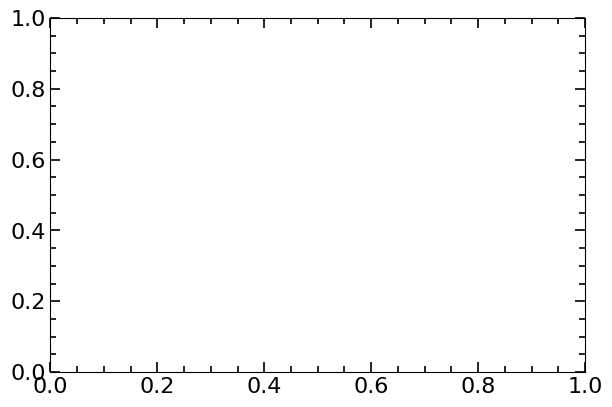

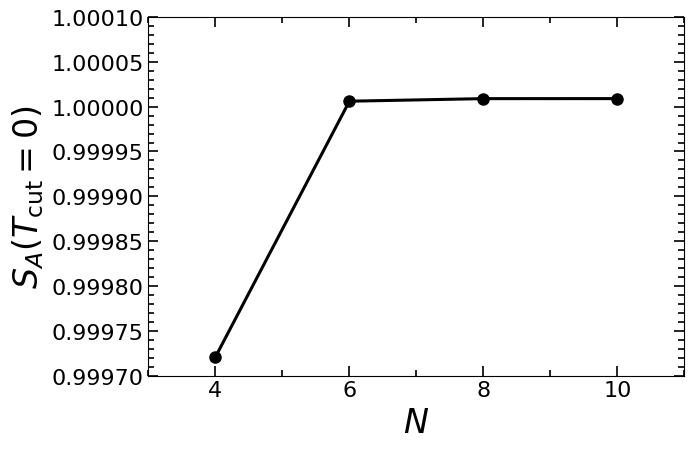

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.patheffects as pe
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from scipy.optimize import curve_fit

# ----------------- Helper Functions -----------------

def label_at(ax, x, y, text, *, coord='data', dx_pt = 8, fontsize=14, color=None):
    """グラフにテキストラベルを付加する関数（白フチ付き）"""
    kw = dict(ha='left', va='center', fontsize=fontsize, xytext=(dx_pt, 0), 
              textcoords='offset points', 
              path_effects=[pe.withStroke(linewidth = 3, foreground='white')], 
              clip_on=False, zorder=6)
    if color is not None:
        kw['color'] = color
    if coord == 'axes':
        ax.annotate(text, xy = (x, y), xycoords = ax.transAxes, **kw)
    else:
        ax.annotate(text, xy = (x, y), xycoords = 'data', **kw)

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    """内向きの目盛りを設定する関数"""
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)
    
# ----------------- Plotting Configuration -----------------

markers = ['o', '^', 's', 'D', 'v', '<', '>']

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,     # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
    "legend.fontsize": 14,
})

# ----------------- Data Setting -----------------

hx_list = [0.1] 
N_list = [4, 6, 8, 10]
J = 1.0

# ----------------- Main Plotting Logic -----------------

fig, ax = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax)

# ax.set_title(fr"$S_A(t=0)$ vs $N$ for $J={J}$")

# 1. 各 hx ごとに S_A(t=0) を計算し、プロット
for i, hx in enumerate(hx_list):
    resi_EE = [] # S_A(t=0) を格納するリスト
    
    print(f"--- Calculating for hx = {hx} ---")
    
    # T_cut = 0 での S_A を N の各値で計算
    for j, N in enumerate(N_list):
        # T_cut = 0 でシミュレーション
        try:
            ee_T = simulate(N=N, J = J, hx = hx, T_cut=0)
            resi_EE.append(float(ee_T))
            # print(f"N = {N}, S_A(t=0) = {ee_T:.4f}")
        except ValueError as e:
            print(f"Error for N={N}: {e}")
            break
            
    resi_EE = np.asarray(resi_EE)
    print(resi_EE)
    
    if len(resi_EE) == 0:
        continue
    
    # 2. プロット
    mk = markers[i % len(markers)] # マーカーを選択
    
    # データ点をプロット
    ln, = ax.plot(N_list[:len(resi_EE)], resi_EE, marker=mk, 
                  markersize=8.0, linestyle='-', label=fr"$h_x={hx:g}$", color='k')

# 3. グラフの装飾
ax.set_xlabel(r"$N$", fontsize=24)
ax.set_ylabel(r"$S_A(T_{\rm cut} =0)$", fontsize=24)

# X軸の設定 (Nは整数なので、整数目盛りを使う)
ax.set_xlim(min(N_list) - 1, max(N_list) + 1)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

# Y軸の設定 (適切な範囲に調整)
# 最大値に余裕を持たせる
ax.set_ylim(0.9997, 1.0001)

ax.ticklabel_format(axis='y', style='plain', useOffset=False)

# 凡例の表示 (複数の hx がある場合)
# if len(hx_list) > 1 or len(hx_list) == 1:
    # ax.legend(loc='lower right', frameon=False)


# 4. 保存と表示
fig.tight_layout()

nstamp = '-'.join(map(str, N_list))
h_stamp = '_'.join(map(str, hx_list))
OUTDIR = Path("../charts/TFIM"); OUTDIR.mkdir(parents=True, exist_ok=True)
output_filename = OUTDIR / f"SA0_vs_N_hx_{h_stamp}_N_{nstamp}_expand.pdf"

fig.savefig(output_filename, bbox_inches="tight", dpi=300)
# print(f"Plot saved to {output_filename}")

plt.show()